In [70]:
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
import probscale
import scipy
import scipy.stats as stats
import math

In [ ]:
# Feel free to use any of the matplot styles that fit your fancy
# link to the doc: https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('fivethirtyeight')

# Needed Until reformat of BGT Upgrade is complete
def format_df(df):
    print(len(df))
    df = df.rename(columns={'BGTJobId':'Job ID'})
    return df

# Import relevant dataframes:
main_table = pd.read_parquet(r"A:\All_Higher_Ed_Jobs.parquet")
# print(len(main_table))
main_table = format_df(main_table)

faculty_table = pd.read_parquet(r"A:\Faculty_and_Postdoc_Detailed_Fields.parquet")
# print(len(faculty_table))
faculty_table = format_df(faculty_table)

skill_table = pd.read_parquet(r"A:\All_Higher_Ed_Skills.parquet")
# print(len(skill_table))
skill_table = format_df(skill_table)

In [62]:
def BEA_zone(state):
    
    dictionary = {'KS': 'Plains',
                  'MS': 'Southeast',
                  'NM': 'Southwest',
                  'MN': 'Plains',
                  'GA': 'Southeast',
                  'TN': 'Southeast',
                  'PA': 'Mideast',
                  'OH': 'Great Lakes',
                  'WI': 'Great Lakes',
                  'NJ': 'Mideast',
                  'TX': 'Southwest',
                  'AZ': 'Southwest',
                  'CA': 'Far West',
                  'MA': 'New England',
                  'FL': 'Southeast',
                  'RI': 'New England',
                  'NC': 'Southeast',
                  'IL': 'Great Lakes',
                  'KY': 'Southeast',
                  'NV': 'Far West',
                  'CO': 'Rocky Mountains',
                  'DC': 'Mideast',
                  'VA': 'Southeast',
                  'IA': 'Plains',
                  'UT': 'Rocky Mountains',
                  'IN': 'Great Lakes',
                  'NH': 'New England',
                  'OR': 'Far West',
                  'MO': 'Plains',
                  'DE': 'Mideast',
                  'CT': 'New England',
                  'MI': 'Great Lakes',
                  'SC': 'Southeast',
                  'MT': 'Rocky Mountains',
                  'OK': 'Southwest',
                  'NY': 'Mideast',
                  'ID': 'Rocky Mountains',
                  'WV': 'Southeast',
                  'MD': 'Mideast',
                  'AK': 'Far West',
                  'AR': 'Southeast',
                  'NE': 'Plains',
                  'AL': 'Southeast',
                  'LA': 'Southeast',
                  'WA': 'Far West',
                  'HI': 'Far West',
                  'VT': 'New England',
                  'ME': 'New England',
                  'SD': 'Plains',
                  'WY': 'Rocky Mountains',
                  'ND': 'Plains',
                  'PR': 'Territories',
                  'GU': 'Territories',
                  'VI': 'Territories',
                  'MP': 'Territories',
                  'AS': 'Territories',
                  'MH': 'Territories',
                  'FM': 'Territories'}
    
    if type(state) is str and state == 'na':
        return None
    elif type(state) is str:
        return dictionary[state]
    elif state is None:
        return None
    
main_table['BEA_zone']=main_table['State'].apply(BEA_zone)

In [73]:
#############################################################
# Generating Institution based State and BEA_zone identifiers
#############################################################
# 01/19/2020

main = main_table.copy()

# Get all states that each institution is found in and the number of postings in those states
states = pd.DataFrame(main_table.groupby(['IPEDS Institution Name', 'State']).count()['Job ID'])

# Get ['IPEDS Institution Name', 'State'] as workable columns
states = states.reset_index()

# Resort the table lexicographically by institution name, and descending by number of postings within
states = states.sort_values(by=['IPEDS Institution Name', 'Job ID'], ascending=[True, False])

# Drop duplicates on institution s.t. only the top counted state is kept
states = states.drop_duplicates('IPEDS Institution Name')

# Dictionary for mapping institution to its most common state
mapping = {}

def populate_mapping(row, mapping):
    '''
    Method for mapping each Institution with its primary state. Meant to be caled with the
    Pandas.DataFrame.apply() function.
    '''
    
    mapping[row['IPEDS Institution Name']] = row['State']
    
# Get mapping    
states.apply(populate_mapping, axis=1, args=(mapping,))

# Function returns the primary state of the institution
def primary_state(inst):
    if type(inst) is str and inst == 'na':
        return None
    elif type(inst) is str:
        try:
            return mapping[inst]
        except KeyError:
            return None
    elif inst is None:
        return None
        
# Generate new 'Institution State' column for main table and BEA_zone from that
main['Institution_State'] = main['IPEDS Institution Name'].apply(primary_state)
main['Institution_BEA_zone'] = main['Institution_State'].apply(BEA_zone)

# Fix previous BEA_zone column
main['BEA_zone'] = main['State'].apply(BEA_zone)

main_table = main

In [74]:
# Series of post-doc IDs useful for isolating all ['Post-Doctoral' = 1] postings by Job ID
mask = main_table[main_table['Postdoc']==1][['Job ID']]
print(len(mask))
# This can then be used to perform a natural join on any of the above tables and extract
# post-doc only data. It is far simpler than trying to isolate the post-doc data using the
# faculty table each time; it saves memory and time as well!

############################################################
# General Functions
############################################################

def breakout(df, year, category):
    '''
    Generalized breakout for obtaining sizes of categories within a data column.
    
    Parameters:
    df (DataFrame): Full Pandas DataFrame used as the source for the breakout
    year (int): The year to which df will be restricted
    category (string): The cateogry by which the user would like to break out
    
    Returns:
    DataFrame with 
    '''
    num = df['Job ID'].nunique()
    df = df[df['Year']==year]
    cat = pd.DataFrame(df[category].value_counts()).reset_index()
    cat = cat.rename(columns={category:'count'})
    cat['inc'] = np.true_divide(cat['count'], num)
    
    return cat.sort_values(by='count', ascending=False)

def growth(df1, df2):
    df = df1.merge(df2, on='index', how='outer', indicator=True)
    df = df[df['_merge']=='both']
#     df['growth'] = np.true_divide(df['inc_y'] - df['inc_x'], df['inc_x'])
    df['growth'] = np.true_divide(df['count_y'] - df['count_x'], df['count_x'])
    return df.sort_values('growth', ascending=False).reset_index(drop=True)
    
############################################################
# Visualization 1)
# Post-Doc vs HEJP baseline by BEA Zone
############################################################    

# Use mask to obtain main_table subset that contains strictly post-doc postings
post = main_table.merge(mask, on='Job ID', how='inner')
post = post[~post['IPEDS Institution Name'].isnull()]

# Store the complement of this subset (all non-post-doc postings)
main = main_table.drop(post.index)
main = main[main['BEA_zone']!='Territories']

year1 = 2007
year2 = 2017

main_zone1 = breakout(main, year1, 'Institution_BEA_zone')
main_zone2 = breakout(main, year2, 'Institution_BEA_zone')

main_zone_g = growth(main_zone1, main_zone2)

zone1 = breakout(post, year1, 'Institution_BEA_zone')
zone2 = breakout(post, year2, 'Institution_BEA_zone')

zone_g = growth(zone1, zone2)

62696


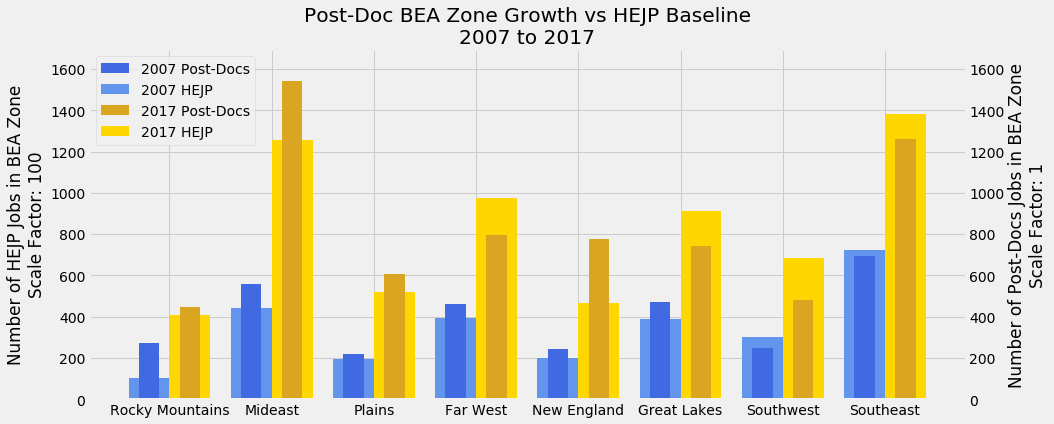

In [77]:
# Superimposed Categorical growth:
#     Two dataframes are used to graph categorical changes across two datasets and
#     two time periods. An example of this is postings within the post-doc bucket being
#     comapared to postings in HEJP as a whole in 2007 and 2017.
def super_graph_growth(df1, df2, category, years, title, type1, type2, colors1, colors2, scale1=1, scale2=1, top=10):
    '''
    Don't worry about this method. This is simply matplot code to generate the visual 
    for your convenience.
    
    If you choose to fiddle with it, do so by modifying the input arguments of the function.
    '''
    
    comb = df1.merge(df2, on='index', how='inner')
    comb = comb.sort_values(by='growth_y', ascending=False)
    comb = comb[:top]
    
#     display(comb)
    
    labels = comb['index'].values
    ind = np.arange(len(labels))
    width = 0.4
    
    first1 = comb['count_x_x'].values/scale1
    first2 = comb['count_y_x'].values/scale1
    
    second1 = comb['count_x_y'].values/scale2
    second2 = comb['count_y_y'].values/scale2
    
    top_y = max(max(np.amax(first1), np.amax(first2)), max(np.amax(second1), np.amax(second2))) * 1.1
    
    fig, ax2 = plt.subplots(figsize=(14, 6))
    
    bar3 = ax2.bar(ind-width/2, second1, width, color=colors2[0], label=str(years[0]) + ' ' + type2)
    bar4 = ax2.bar(ind+width/2, second2, width, color=colors2[1], label=str(years[1]) + ' ' + type2)
    
    ax2.set_ylim(top=top_y)
    ax2.set_ylabel('Number of ' + type2 + ' Jobs in ' + category + '\nScale Factor: ' + str(scale2))
    
    ax1 = ax2.twinx()
    ax1.grid(False)
    
    bar1 = ax1.bar(ind-width/2, first1, width/2, color=colors1[0], label=str(years[0]) + ' ' + type1)
    bar2 = ax1.bar(ind+width/2, first2, width/2, color=colors1[1], label=str(years[1]) + ' ' + type1)
    
    ax1.set_ylim(top=top_y)
    ax1.set_ylabel('Number of ' + type1 + ' Jobs in ' + category + '\nScale Factor: ' + str(scale1))
    
    plt.xticks(ind, labels, rotation=45, ha='right')
    plt.xlabel(category)
    
    bars = [bar1, bar3, bar2, bar4]
    labs = [b.get_label() for b in bars]
    plt.legend(bars, labs, loc='best')
    
    plt.title(title)
    
    plt.show()

# Graph Post-Doc vs HEJP baseline superimposed
super_graph_growth(zone_g, main_zone_g, 'BEA Zone', (2007, 2017), 'Post-Doc BEA Zone Growth vs HEJP Baseline\n2007 to 2017', 
                   'Post-Docs', 'HEJP', ('royalblue', 'goldenrod'), ('cornflowerblue', 'gold'), scale2=100)

In [78]:
############################################################
# Visualization 2)
# Overall Categorical Size Changes 2007-2017
############################################################  

# Total Categorical Size Changes

year1 = 2007
year2 = 2017

post = main_table.merge(mask, on='Job ID', how='inner')
main = main_table.drop(post.index)

post1 = post[post['Year']==year1]['Job ID'].nunique()
main1 = main[main['Year']==year1]['Job ID'].nunique()

post2 = post[post['Year']==year2]['Job ID'].nunique()
main2 = main[main['Year']==year2]['Job ID'].nunique()


table = pd.DataFrame([['Post-Doc', post1, post2], ['HEJP (No PD)', main1, main2]], columns=['Type', year1, year2])

table['growth'] = np.true_divide(table[year2]-table[year1], table[year1])

display(table)
 

,Type,2007,2017,growth
0,Post-Doc,3245,6836,1.106626
1,HEJP (No PD),287290,708433,1.465916


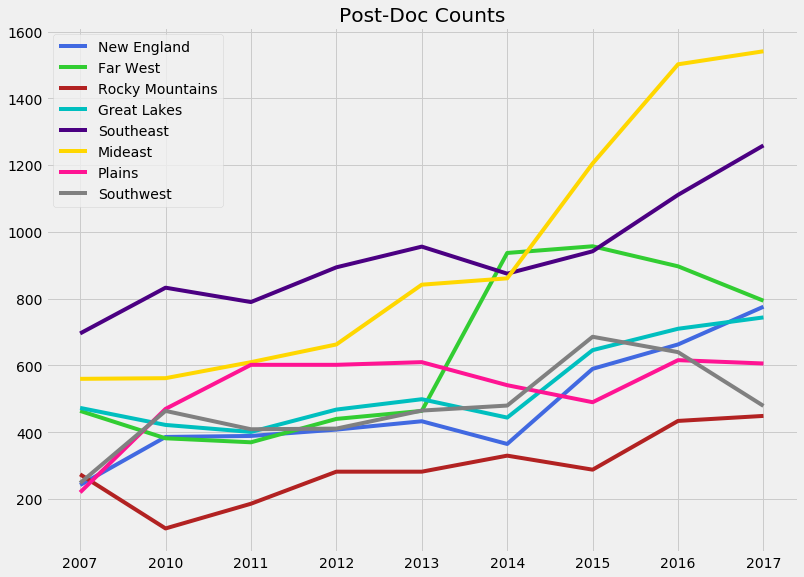

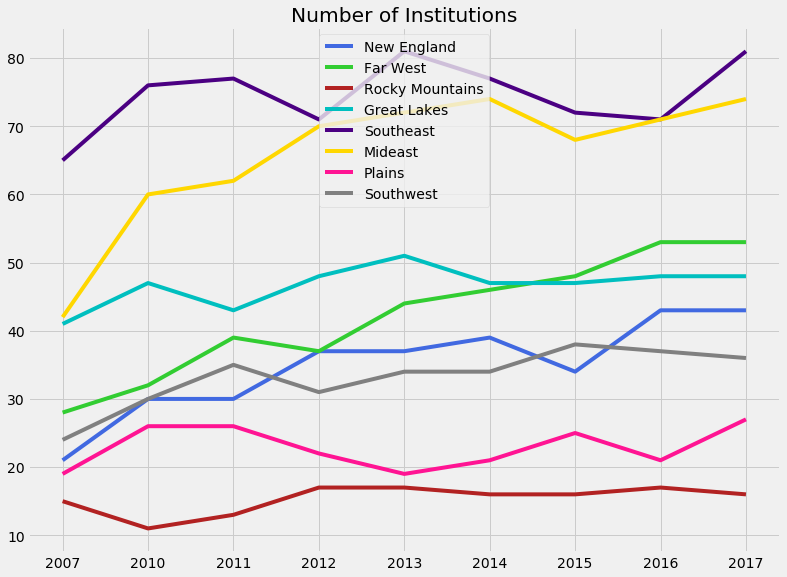

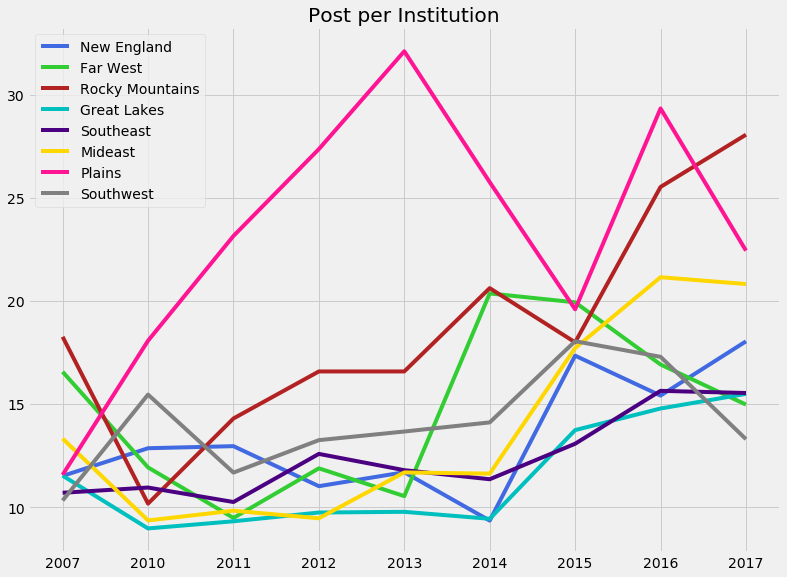

,New England,Far West,Rocky Mountains,Great Lakes,Southeast,Mideast,Plains,Southwest
0,43.000000,53.000000,16.0000,48.0,81.00000,74.000000,27.000000,36.000000
1,18.046512,14.981132,28.0625,15.5,15.54321,20.824324,22.444444,13.305556


In [79]:
############################################################
# Visualization 3 & 4)
# Number of Post-Docs per region every year 2007-2010
############################################################ 
                      
post = main_table.merge(mask, on='Job ID', how='inner')
post = post[~post['IPEDS Institution Name'].isnull()]
years = [2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
# Take the first 8 to avoid 'Territories'
zones = list(post['Institution_BEA_zone'].unique())[:8]
# zones = ['Plains', 'Mideast', 'New England']
tensor = np.zeros((len(years), 3, 0))

post = pd.DataFrame(post.groupby(['Institution_BEA_zone', 'Year', 'IPEDS Institution Name']).count()['Job ID']).reset_index()

# This loop composes a 3d array that has this structure
# (Year number, 1 of 3 metrics [Post-Doc counts, institution counts, post-docs per institution], BEA_zones)
for zone in zones:
    DF = post[post['Institution_BEA_zone']==zone]
    tuples = np.zeros((0, 3))
    for year in years:
        df = DF[DF['Year']==year]
        
#         df = df[df['Job ID']>=6]
    
        jobs = df['Job ID'].sum()
        inst = df['IPEDS Institution Name'].nunique()

        per = jobs/inst

        tuples = np.vstack((tuples, np.array((jobs, inst, per))))
    
    tensor = np.dstack((tensor, tuples))

ind = np.arange(len(years))
colors = ['royalblue', 'limegreen', 'firebrick', 'c', 'indigo', 'gold', 'deeppink', 'grey']
titles = ['Post-Doc Counts', 'Number of Institutions', 'Post per Institution']

# This makes line graphs of all three metrics, but in the presentation we only used the first in a line graph
for i in range(3):
    fig, ax = plt.subplots(figsize=(12,9))
    for j in range(len(zones)):
        ax.plot(tensor[:,i,j], color=colors[j], label=zones[j])
    plt.title(titles[i])
    plt.xticks(ind, years)
    plt.legend(loc='best')
    plt.show()
    
# Isolate Institution and per capita numbers in the most recent year (2017)
df = pd.DataFrame(tensor[8,1:,:])

# Make the columns readable
for i in range(len(zones)):
    df = df.rename(columns={i:zones[i]})

display(df)

In [81]:
############################################################
# Visualization 5)
# Top States with postings outside their borders
############################################################ 

post = main_table.merge(mask, on='Job ID', how='inner')

cat1 = 'Institution_State'
cat2 = 'State'

# cat1 = 'Institution_BEA_zone'
# cat2 = 'BEA_zone'

# Get all combinations of institution state and state
diff = pd.DataFrame(post.groupby(['Year', cat1, cat2]).count()[['Job ID']]).reset_index()
# Throw out observations in the same state
diff = diff[diff[cat1]!=diff[cat2]]

# Regroup by the Institution state
diff = pd.DataFrame(diff.groupby([cat1]).sum()).reset_index()[['Institution_State', 'Job ID']]

diff.sort_values(by='Job ID', ascending=False)[:10]

,Institution_State,Job ID
23,MO,204
18,MA,202
14,IN,198
46,WA,193
3,CA,187
41,TX,161
26,NC,143
43,VA,131
32,NY,124
36,PA,88


Economics


,index,count_x,inc_x,count_y,inc_y,change,growth
5,Econometrics,2.0,0.045455,38,0.220930,0.175476,3.860465
3,Public Health and Safety,3.0,0.068182,39,0.226744,0.158562,2.325581
1,Teaching,9.0,0.204545,51,0.296512,0.091966,0.449612
4,Data Analysis,2.0,0.045455,19,0.110465,0.065011,1.430233
8,Data Collection,1.0,0.022727,15,0.087209,0.064482,2.837209
6,MATLAB,2.0,0.045455,16,0.093023,0.047569,1.046512
7,STATA,2.0,0.045455,16,0.093023,0.047569,1.046512
0,Economics,37.0,0.840909,151,0.877907,0.036998,0.043997
2,Psychology,8.0,0.181818,31,0.180233,-0.001586,-0.008721
9,Grant Writing,NaN,NaN,18,0.104651,NaN,NaN


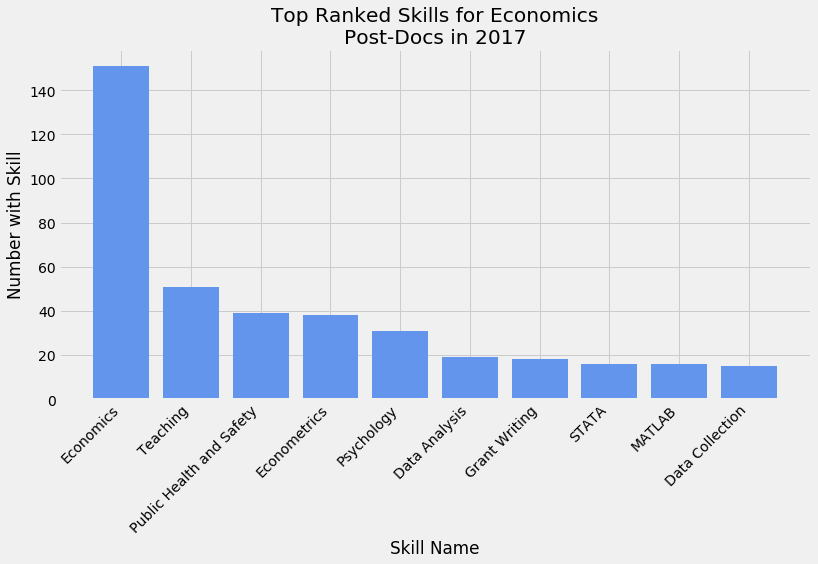

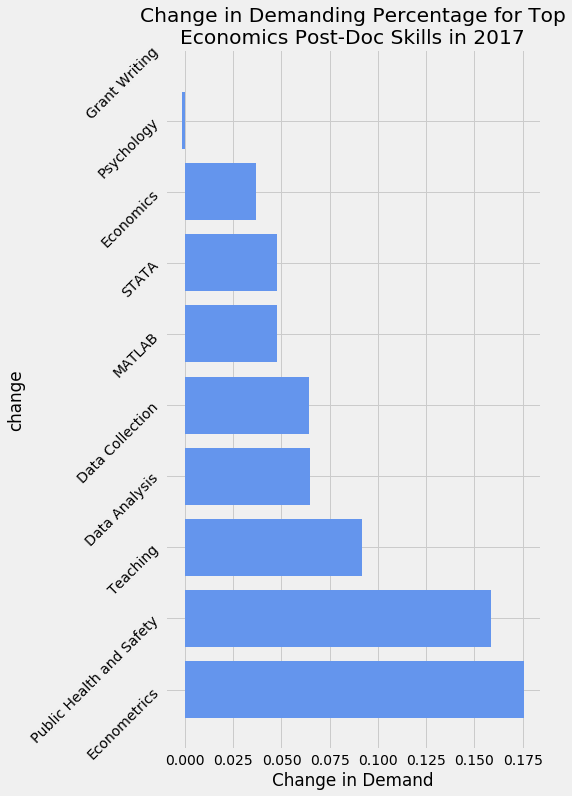

Chemistry


,index,count_x,inc_x,count_y,inc_y,change,growth
3,Biology,116,0.209009,251,0.305353,0.096344,0.460955
9,Microscope,40,0.072072,124,0.150852,0.078780,1.093066
5,Experiments,97,0.174775,201,0.244526,0.069751,0.399089
8,Immunohistochemistry,48,0.086486,127,0.154501,0.068015,0.786420
0,Biochemistry,286,0.515315,446,0.542579,0.027264,0.052907
7,Cell Culturing,63,0.113514,108,0.131387,0.017873,0.157456
6,Cancer knowledge,81,0.145946,108,0.131387,-0.014559,-0.099757
4,Cell Biology,100,0.180180,136,0.165450,-0.014730,-0.081752
2,Molecular Biology,238,0.428829,337,0.409976,-0.018853,-0.043964
1,Chemistry,266,0.479279,371,0.451338,-0.027941,-0.058298


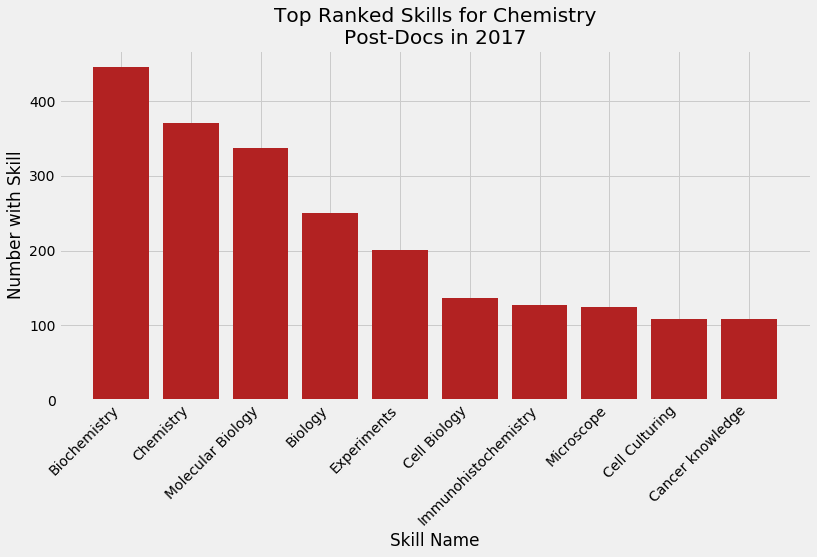

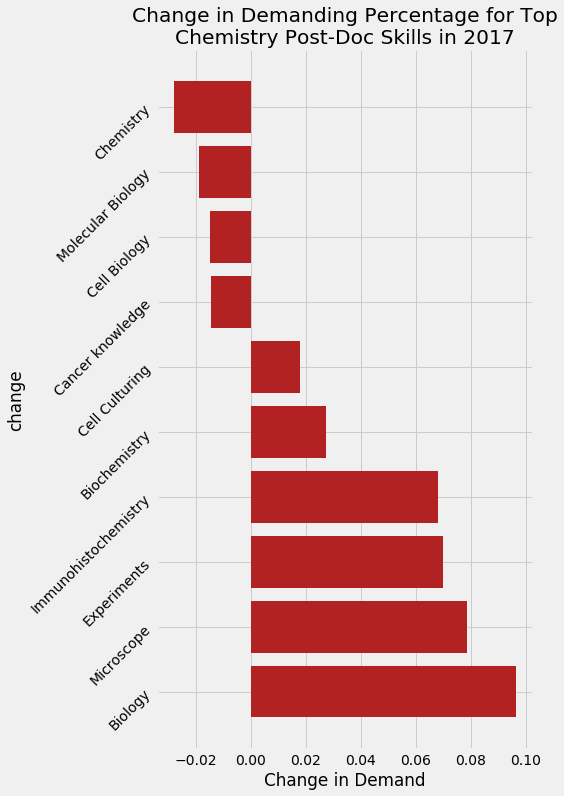

Biological_and_Biomedical_Sciences


,index,count_x,inc_x,count_y,inc_y,change,growth
1,Biology,330,0.272953,797,0.368299,0.095347,0.349315
5,Experiments,203,0.167907,521,0.240758,0.072850,0.433873
9,Bioinformatics,149,0.123242,412,0.190388,0.067146,0.544828
8,Genetics,164,0.135649,366,0.169131,0.033482,0.246827
2,Neuroscience,269,0.222498,523,0.241682,0.019184,0.086222
7,Pathology,179,0.148056,324,0.149723,0.001666,0.011256
4,Biochemistry,212,0.175352,377,0.174214,-0.001137,-0.006485
3,Physiology,216,0.178660,374,0.172828,-0.005832,-0.032643
6,Cell Biology,199,0.164599,316,0.146026,-0.018573,-0.112838
0,Molecular Biology,459,0.379653,756,0.349353,-0.030300,-0.079809


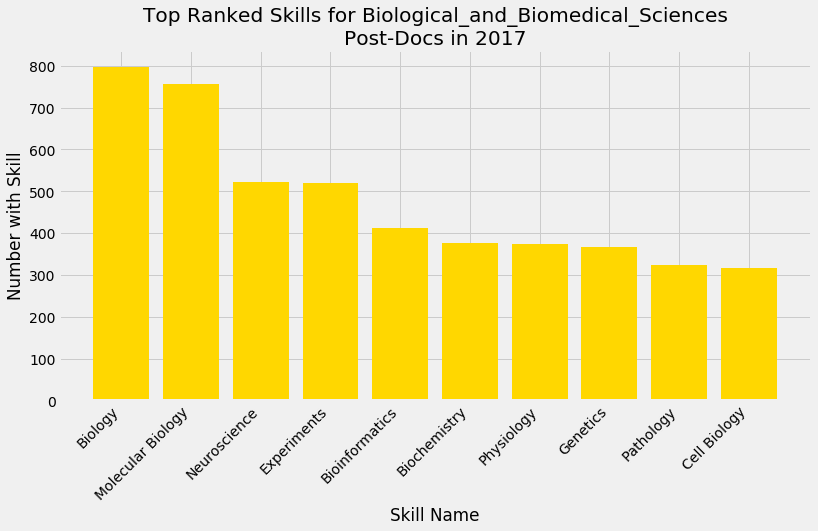

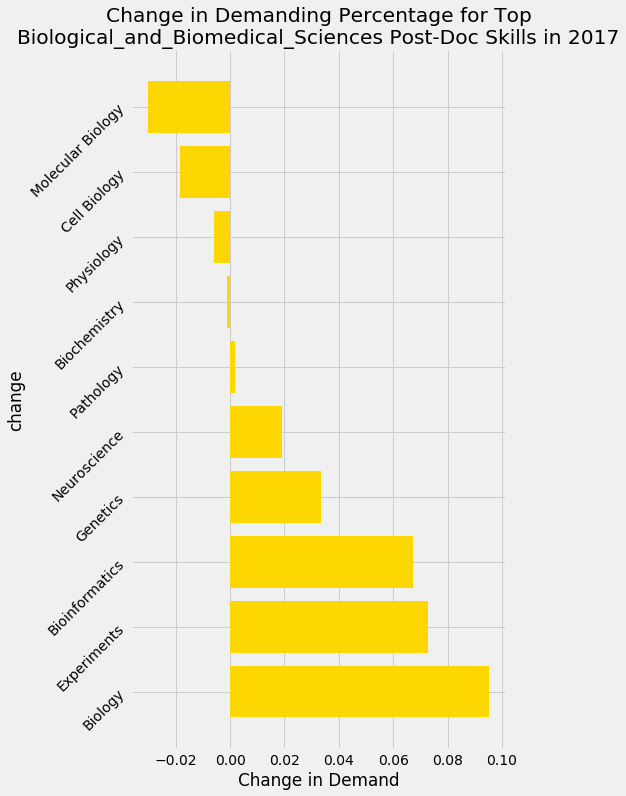

In [89]:
############################################################
# Visualization 6)
# Skill Changes backed in from 2017
############################################################ 

# Obtain isolated post-doctoral skill dataframe
skill_small = skill_table[(skill_table['Year']==2010)|(skill_table['Year']==2017)]

skill_p = skill_small.merge(mask, on='Job ID', how='inner')
# skill_f = skill_table.drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).merge(faculty_table[faculty_table['Faculty']==1][['Job ID']], 
#                                                                          on='Job ID', how='inner')

# Method for isolating the skills in a year
def skill_break(df, year, NSF=None):
    df = df[df['Year']==year]
    s_df = df[df['Is Specialized Skill?']==1]
    
    if NSF is not None:
        mask = faculty_table[faculty_table[NSF]==1][['Job ID']]
        df = df.merge(mask, on='Job ID', how='inner')
        s_df = s_df.merge(mask, on='Job ID', how='inner')
    
    skills = pd.DataFrame(df['Skill Name'].value_counts()).reset_index()
    skills = skills.rename(columns={'Skill Name':'count'})
    skills['inc'] = np.true_divide(skills['count'], df['Job ID'].nunique())
    
    s_skills = pd.DataFrame(s_df['Skill Name'].value_counts()).reset_index()
    s_skills = s_skills.rename(columns={'Skill Name':'count'})
    s_skills['inc'] = np.true_divide(s_skills['count'], s_df['Job ID'].nunique())
    
    return skills, s_skills

# Method for graphing the raw ranks of the skills
def s_graph_rank(df, title, color='blue', top=10):
    
    df = df[:top]
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    labels = df['index'].values
    counts = df['count'].values
    
    ind = np.arange(len(labels))
    
    ax.bar(ind, counts, color=color)
    
    plt.xticks(ind, labels, rotation=45, ha='right')
    plt.xlabel('Skill Name')
    plt.ylabel('Number with Skill')
#     plt.legend(loc='upper right')
    plt.title(title)
    
    plt.show()

# Define NSF fields of intrest
nsfs = ['Economics', 'Chemistry', 'Biological_and_Biomedical_Sciences']
colors = [('royalblue', 'cornflowerblue'),('maroon', 'firebrick'),('goldenrod', 'gold'),('darkgreen', 'forestgreen'),
          ('indigo', 'rebeccapurple')]
year1 = 2010
year2 = 2017

def s_graph_growth(df, title, color='blue', top=10):
    
    df = df[:top]
    
    fig, ax = plt.subplots(figsize=(6,12))
    
    labels = df['index'].values
    counts = df['change'].values
    
    ind = np.arange(len(labels))
    
    ax.barh(ind, counts, color=color)
    
    plt.yticks(ind, labels, rotation=45, ha='right')
    plt.ylabel('change')
    plt.xlabel('Change in Demand')
#     plt.legend(loc='upper right')
    plt.title(title)
    
    plt.show()

def get_diffs(df):
    df['change'] = df['inc_y'] - df['inc_x']
    df['growth'] = np.true_divide(df['inc_y'] - df['inc_x'], df['inc_x'])
    return df.sort_values(by='change', ascending=False)

for i in range(len(nsfs)):
    nsf = nsfs[i]
    color = colors[i]
    
    print(nsf)
    
    # Faculty dataframes are commneted out
    
    skills1, s_skills1 = skill_break(skill_p, year1, NSF=nsf)
#     main_skills1, main_s_skills1 = skill_break(skill_f, year1, NSF=nsf)

    skills2, s_skills2 = skill_break(skill_p, year2, NSF=nsf)
#     main_skills2, main_s_skills2 = skill_break(skill_f, year2, NSF=nsf)

#     fac_s = main_s_skills1.merge(main_s_skills2[:10], on='index', how='right')
#     fac_s = get_diffs(fac_s)
    
    post_s = s_skills1.merge(s_skills2[:10], on='index', how='right')
    post_s = get_diffs(post_s)
    
    display(post_s)
    
    s_graph_rank(s_skills2, 'Top Ranked Skills for ' + nsf + '\nPost-Docs in 2017', color=color[1])
    s_graph_growth(post_s, 'Change in Demanding Percentage for Top\n' + nsf + ' Post-Doc Skills in 2017', color=color[1])
    

In [92]:
skill_table[skill_table['Skill Name'].str.contains('ethics', na=False, case=False)]

,Job ID,Year,Skill Name,Is Specialized Skill?,Is Software Skill?,Skill Cluster Name
92853,38317306383,2018.0,Ethics and Participant Safety,1.0,0.0,None
186157,284955400,2011.0,Ethics and Participant Safety,1.0,0.0,None
221235,38098206928,2016.0,Ethics and Participant Safety,1.0,0.0,None
238234,38120230243,2016.0,Ethics and Participant Safety,1.0,0.0,None
252818,38414962585,2018.0,Ethics and Participant Safety,1.0,0.0,None
319905,38551764306,2019.0,Ethics and Participant Safety,1.0,0.0,None
342208,38583976609,2019.0,Ethics and Participant Safety,1.0,0.0,None
360051,38418870932,2018.0,Ethics and Participant Safety,1.0,0.0,None
361055,38579073388,2019.0,Ethics and Participant Safety,1.0,0.0,None
604353,37929593705,2015.0,Ethics and Participant Safety,1.0,0.0,None


In [95]:
mask = faculty_table[faculty_table['Other_Humanities_and_Arts']==1][['Job ID']]

In [100]:
main = mask.merge(main_table, how='inner')

print(len(mask))

target_mask = main[main['Job Title'].str.contains('Ethics', na=False, case=False)|
     main['Job Title'].str.contains('Philosophy', na=False, case=False)][['Job ID']]

target_mask = pd.concat([target_mask, skill_table[skill_table['Skill Name'].str.contains(
    'Ethics', case=False, na=False)][['Job ID']]]).drop_duplicates()

target = main_table.merge(target_mask, on='Job ID', how='inner')

122965


In [101]:
target

,Job ID,LIJobId,Year,Faculty,Postdoc,Diversity,Job Title,Occupation,Career Area,Minimum EDU Requirements,Maximum EDU Requirements,Minimum Experience Requirements,Annual Salary,Metropolitan Statistical Area,State,IPEDS Institution Name,IPEDS Sector Name,Is Research 1 Institution?,BEA_zone,Institution_State,Institution_BEA_zone
0,320100951,195074683,2007.0,1.0,0.0,0.0,"Assistant Or Associate Professor Of Philosophy And Religion, Normative And Applied Ethics",College Professor / Instructor,Education and Training,NaN,NaN,NaN,NaN,na,MD,Washington College,"Private not-for-profit, 4-year or above",0.0,Mideast,MD,Mideast
1,320173276,196224313,2007.0,1.0,0.0,0.0,"Assistant Professor, Philosophy And Humanities Department",College Professor / Instructor,Education and Training,21.0,NaN,1.000000,NaN,"Buffalo-Cheektowaga-Niagara Falls, NY",NY,None,None,0.0,Mideast,None,None
2,327051701,195505772,2007.0,1.0,0.0,0.0,"Philosophy, Instructor Fixed Term",College Professor / Instructor,Education and Training,NaN,NaN,NaN,NaN,"Mankato-North Mankato, MN",MN,University of Minnesota-Twin Cities,"Public, 4-year or above",1.0,Plains,MN,Plains
3,38018627866,0xc9c6fd46bfd02a5742d7529395751fcb,2016.0,1.0,0.0,0.0,Philosophy Adjunct Instructor,College Professor / Instructor,Education and Training,18.0,NaN,2.000000,NaN,"San Antonio-New Braunfels, TX",TX,The Art Institute of San Antonio,"Private for-profit, 4-year or above",0.0,Southwest,TX,Southwest
4,334049767,195245511,2007.0,1.0,0.0,0.0,Assistant Professor - Philosophy,College Professor / Instructor,Education and Training,NaN,NaN,NaN,NaN,"Los Angeles-Long Beach-Anaheim, CA",CA,University of California-System Administration Central Office,Administrative Unit,0.0,Far West,CA,Far West
5,320335351,202060122,2007.0,1.0,0.0,0.0,Assistant Professor Of Philosophy 73313T,College Professor / Instructor,Education and Training,NaN,NaN,NaN,NaN,"Hilo, HI",HI,University of Hawaii System Office,Administrative Unit,0.0,Far West,HI,Far West
6,321574219,193732834,2007.0,1.0,0.0,0.0,Chaplain/Instructor Of Religion/Philosophy,College Professor / Instructor,Education and Training,NaN,NaN,NaN,NaN,"Quincy, IL-MO",MO,Culver-Stockton College,"Private not-for-profit, 4-year or above",0.0,Plains,MO,Plains
7,319775504,193002377,2007.0,1.0,0.0,0.0,"Assistant Professor, Philosophy",College Professor / Instructor,Education and Training,21.0,21.0,NaN,NaN,"Oneonta, NY",NY,Hartwick College,"Private not-for-profit, 4-year or above",0.0,Mideast,NY,Mideast
8,331293491,203672453,2007.0,1.0,0.0,0.0,Lecturer - Philosophy,College Professor / Instructor,Education and Training,NaN,NaN,NaN,NaN,"Wilmington, NC",NC,University of North Carolina at Chapel Hill,"Public, 4-year or above",1.0,Southeast,NC,Southeast
9,331850765,233697729,2007.0,1.0,0.0,0.0,Instructor - Philosophy,College Professor / Instructor,Education and Training,NaN,NaN,NaN,NaN,"Hattiesburg, MS",MS,University of Southern Mississippi,"Public, 4-year or above",1.0,Southeast,MS,Southeast
